In [7]:
import os
os.listdir('./../data/')

['imu_data_3.csv', 'imu_data_1.csv', 'imu_data_2.csv']

Trajectory integration finished.


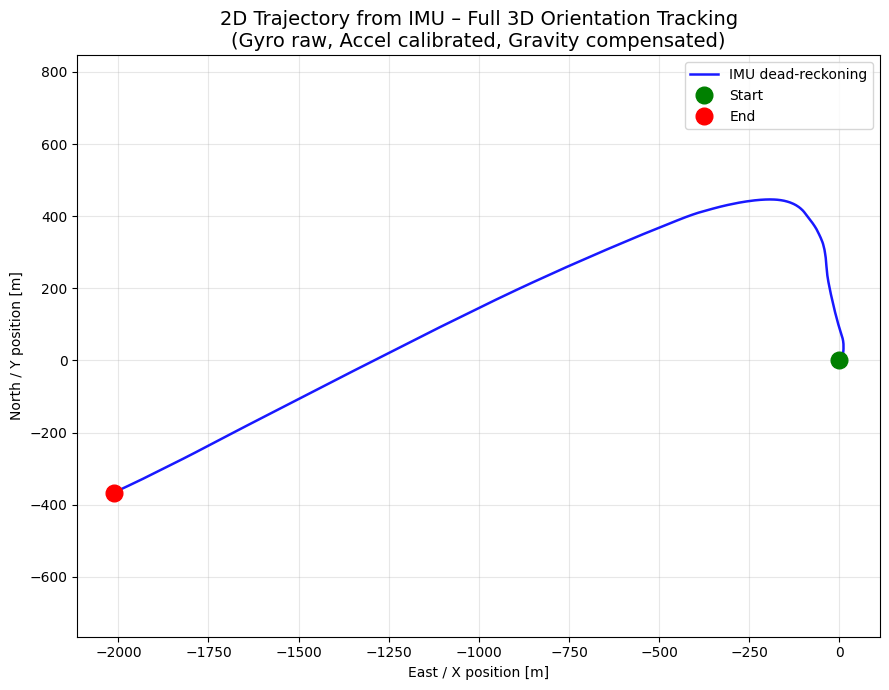

Final position: (-2012.75 m, -366.72 m)
Total distance traveled (straight-line): 2045.89 m


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# -------------------------- Load data --------------------------
data_path = './../data/imu_data_1.csv'
data_path = './../../imu_data_1.csv'
imu_data = pd.read_csv(data_path)

# Convert nanoseconds to seconds
t = imu_data['%time'].to_numpy() * 1e-9

# Raw sensor readings (body frame)
a_body = imu_data[['field.linear_acceleration.x',
                   'field.linear_acceleration.y',
                   'field.linear_acceleration.z']].to_numpy()

w_body = imu_data[['field.angular_velocity.x',
                  'field.angular_velocity.y',
                  'field.angular_velocity.z']].to_numpy()

n = len(t)

# --------------------- Accelerometer calibration ---------------------
# Only bias + scale for accelerometer (gyro is left completely raw)
accel_bias  = np.array([0.060675, -0.035453, -0.006935])   # m/s²
accel_scale = np.array([1.000102, 0.999237, 1.000572])

a_body_cal = (1+accel_scale) * (a_body - accel_bias)   # calibrated body acceleration

# --------------------- Initial attitude from accelerometer ---------------------
# Assume first ~1 second is static or quasi-static to find initial roll/pitch
static_idx = slice(0, min(200, n//10))  # first 200 samples or 10%
a_init = np.mean(a_body_cal[  static_idx  ], axis=0)
g_norm = np.linalg.norm(a_init) 

# Initial roll and pitch from gravity vector (yaw left as 0 → heading will drift)
roll0  = np.arctan2(a_init[1], a_init[2])
pitch0 = np.arcsin(-a_init[0] / g_norm)
yaw0   = 0.0

initial_rotation = R.from_euler('xyz', [roll0, pitch0, yaw0])

# --------------------- Integration loop ---------------------
trajectory = np.zeros((n, 2))   # only X-Y position
velocity   = np.zeros(2)       # horizontal velocity in local frame
attitude   = initial_rotation  # current body → local rotation
GRAVITY    = np.array([0.0, 0.0, 9.81])

for i in range(n-1):
    dt = t[i+1] - t[i]
    
    # --- 1. Update orientation using raw gyroscope only ---
    angular_vel = w_body[i]                     # rad/s, no bias subtraction
    delta_rot   = R.from_rotvec(angular_vel * dt)
    attitude    = attitude * delta_rot           # new body → local rotation
    
    # Rotation matrix (3×3)
    R_bl = attitude.as_matrix()                  # body to local
    
    # --- 2. Transform acceleration to local frame and remove gravity ---
    a_local = R_bl @ a_body_cal[i]               # includes gravity
    a_local_no_g = a_local - GRAVITY             # gravity-free in local frame
    
    # --- 3. Keep only horizontal components (X-Y) ---
    a_xy = a_local_no_g[:2]
    
    # --- 4. Integrate velocity and position (trapezoidal = more accurate) ---
    v_old = velocity.copy()
    velocity += a_xy * dt
    trajectory[i+1] = trajectory[i] + (v_old + velocity) / 2 * dt

print("Trajectory integration finished.")

# --------------------- Plot ---------------------
plt.figure(figsize=(9, 7))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.8, alpha=0.9, label='IMU dead-reckoning')
plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=12, label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=12, label='End')
plt.xlabel('East / X position [m]')
plt.ylabel('North / Y position [m]')
plt.title('2D Trajectory from IMU – Full 3D Orientation Tracking\n(Gyro raw, Accel calibrated, Gravity compensated)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print final displacement
print(f"Final position: ({trajectory[-1,0]:.2f} m, {trajectory[-1,1]:.2f} m)")
print(f"Total distance traveled (straight-line): {np.linalg.norm(trajectory[-1]):.2f} m")